In [1]:
import numpy as np
import bilby

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# mpl.use("agg")

# from cycler import cycler
# from itertools import cycle

# mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

In [3]:
# define the time-domain model
def time_domain_damped_sinusoid(
        time, amplitude, damping_time, frequency, phase, t0):
    """
    This example only creates a linearly polarised signal with only plus
    polarisation.
    """
    plus = np.zeros(len(time))
    tidx = time >= t0
    plus[tidx] = amplitude * np.exp(-(time[tidx] - t0) / damping_time) *\
        np.sin(2 * np.pi * frequency * (time[tidx] - t0) + phase)
    cross = np.zeros(len(time))
    return {'plus': plus, 'cross': cross}

In [4]:
times = np.arange(0, 10, 0.01)

In [5]:
wf = time_domain_damped_sinusoid(times, 1, 0.5, 2, 0, 0)

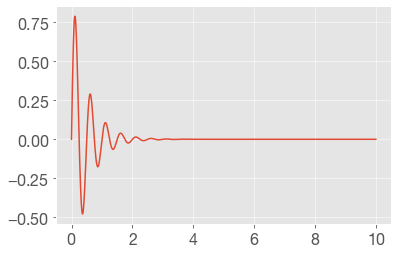

In [6]:
plt.figure()
plt.plot(times, wf['plus'])

In [7]:
# define parameters to inject.
injection_parameters = dict(amplitude=5e-22, damping_time=0.1, frequency=50,
                            phase=0, ra=0, dec=0, psi=0, t0=0., geocent_time=0.)

In [8]:
duration = 1.0
sampling_frequency = 1024
outdir = 'bilby_example_outdir'
label = 'time_domain_source_model'

In [9]:
# call the waveform_generator to create our waveform model.
waveform = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    time_domain_source_model=time_domain_damped_sinusoid,
    start_time=injection_parameters['geocent_time'] - 0.5)

12:49 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: None
  time_domain_source_model: __main__.time_domain_damped_sinusoid
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [10]:
# inject the signal into one interferometers
# ifos = bilby.gw.detector.InterferometerList(['H1', 'L1'])
ifos = bilby.gw.detector.InterferometerList(['H1'])
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=injection_parameters['geocent_time'] - 0.5)
ifos.inject_signal(waveform_generator=waveform,
                   parameters=injection_parameters)

/Users/spx8sk/anaconda3/envs/bilby/lib/python3.7/site-packages/bilby/gw/detector/psd.py:362: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
12:49 bilby INFO    : Injected signal in H1:
12:49 bilby INFO    :   optimal SNR = 7.57
12:49 bilby INFO    :   matched filter SNR = 8.54+0.01j
12:49 bilby INFO    :   amplitude = 5e-22
12:49 bilby INFO    :   damping_time = 0.1
12:49 bilby INFO    :   frequency = 50
12:49 bilby INFO    :   phase = 0
12:49 bilby INFO    :   ra = 0
12:49 bilby INFO    :   dec = 0
12:49 bilby INFO    :   psi = 0
12:49 bilby INFO    :   t0 = 0.0
12:49 bilby INFO    :   geocent_time = 0.0


[{'plus': array([ 1.56680668e-24+0.00000000e+00j,
         -1.58870128e-24+2.03749874e-27j,
          1.56932456e-24-4.03009204e-27j, ...,
         -3.74934358e-26-2.30036653e-30j,
          3.80010222e-26+1.16574269e-30j,
         -3.74919906e-26+0.00000000e+00j]),
  'cross': array([0.+0.j, 0.+0.j, 0.-0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])}]

In [13]:
#  create the priors
prior = injection_parameters.copy()
prior['amplitude'] = bilby.core.prior.LogUniform(1e-23, 1e-21, r'$h_0$')
prior['damping_time'] = bilby.core.prior.Uniform(
    0.01, 1, r'damping time', unit='$s$')
prior['frequency'] = bilby.core.prior.Uniform(0, 200, r'frequency', unit='Hz')
prior['phase'] = bilby.core.prior.Uniform(-np.pi / 2, np.pi / 2, r'$\phi$')

In [14]:
# define likelihood
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(ifos, waveform)

In [15]:
# launch sampler
result = bilby.core.sampler.run_sampler(
    likelihood, prior, sampler='dynesty', npoints=1000,
    injection_parameters=injection_parameters, outdir=outdir, label=label)

12:49 bilby INFO    : Running for label 'time_domain_source_model', output will be saved to 'bilby_example_outdir'
12:49 bilby INFO    : Using lal version 7.1.2
12:49 bilby INFO    : Using lal git version Branch: None;Tag: lalsuite-v6.82;Id: cf792129c2473f42ce6c6ee21d8234254cefd337;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
12:49 bilby INFO    : Using lalsimulation version 2.5.1
12:49 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsuite-v6.82;Id: cf792129c2473f42ce6c6ee21d8234254cefd337;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
12:49 bilby INFO    : Search parameters:
12:49 bilby INFO    :   amplitude = LogUniform(minimum=1e-23, maximum=1e-21, name='$h_0$', latex_label='$h_0$', unit=None, boundary=None)
12:49 bilby INFO    :   damping_time = Uniform(minimum=0.01, maximum=1, name='damping time', latex_label='damping time', unit='$s$', boundary=None)
12:49 bilby INFO    :   frequency = Unifor

0it [00:00, ?it/s]

12:49 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 1000, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 600, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x1459c5c90>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
12:49 bilby INFO    : Checkpoint every check_point_delta_t = 600s
12:49 bilby INFO    : Using dynesty version 1.1
12:49 bilby INFO    : Using the bilby-implemented rwalk sample m

13:03 bilby INFO    : Sampling time: 0:13:31.866110
13:03 bilby INFO    : Summary of results:
nsamples: 16468
ln_noise_evidence: -546.959
ln_evidence: -523.288 +/-  0.152
ln_bayes_factor: 23.670 +/-  0.152



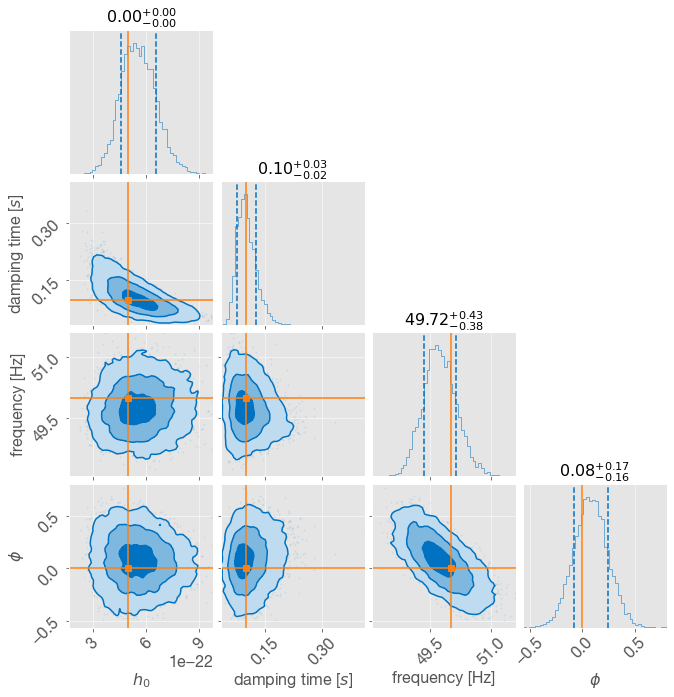

In [16]:
result.plot_corner()